# Análisis de Rendimiento: Minero Proof-of-Work

**Fecha:** 2025-11-09  
**Objetivo:** Comparar el rendimiento de tres modos de ejecución (Sequential, Concurrent, Parallel) con diferentes configuraciones de hilos y dificultades.

## Índice
1. [Carga de Datos](#carga)
2. [Estadísticas Descriptivas](#estadisticas)
3. [Análisis Comparativo por Modo](#comparativo)
4. [Speedup y Eficiencia](#speedup)
5. [Análisis Estadístico](#estadistico)
6. [Visualizaciones](#visualizaciones)
7. [Conclusiones](#conclusiones)

## 1. Carga de Datos

Cargamos todos los resultados experimentales desde la carpeta `results/raw/`.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Librerías cargadas correctamente")

Librerías cargadas correctamente


In [7]:
# Rutas del proyecto
ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
RAW_DIR = ROOT / 'results' / 'raw'
PROCESSED_DIR = ROOT / 'results' / 'processed'

print(f"Directorio raíz: {ROOT}")
print(f"Directorio de datos: {RAW_DIR}")
print(f"Directorio de procesados: {PROCESSED_DIR}")

Directorio raíz: c:\d\Proyectos_programacion\SO_Proyecto_Final
Directorio de datos: c:\d\Proyectos_programacion\SO_Proyecto_Final\results\raw
Directorio de procesados: c:\d\Proyectos_programacion\SO_Proyecto_Final\results\processed


In [ ]:
# Cargar todos los archivos CSV de experimentos
csv_files = list(RAW_DIR.glob('exp_*.csv'))
print(f"Archivos CSV encontrados: {len(csv_files)}")

if len(csv_files) == 0:
    print("⚠️ No se encontraron archivos de resultados.")
    print("   Ejecuta primero los experimentos con: .\\scripts\\run_all_modes.ps1")
else:
    # Cargar todos los CSVs
    dfs = []
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            # Extraer información del nombre del archivo
            filename = csv_file.stem
            parts = filename.split('_')
            df['experiment_id'] = '_'.join(parts[:3])  # exp_mode_config
            df['run_id'] = filename
            dfs.append(df)
        except Exception as e:
            print(f"⚠️ Error al cargar {csv_file.name}: {e}")
    
    if dfs:
        all_data = pd.concat(dfs, ignore_index=True)
        
        # Normalizar nombres de columnas si es necesario
        if 'elapsed_s' in all_data.columns:
            all_data['elapsed_time_s'] = all_data['elapsed_s']
        if 'hashes_per_second' in all_data.columns:
            all_data['throughput_hashes_per_sec'] = all_data['hashes_per_second']
        
        print(f"\n✅ Datos cargados: {len(all_data)} registros de {len(dfs)} archivos")
        print(f"\nColumnas disponibles: {list(all_data.columns)}")
    else:
        print("❌ No se pudieron cargar los datos")

Archivos CSV encontrados: 35

✅ Datos cargados: 35 registros de 35 archivos

Columnas disponibles: ['experiment_id', 'mode', 'difficulty', 'threads', 'affinity', 'found', 'nonce', 'total_hashes', 'elapsed_s', 'cpu_time_s', 'memory_mb', 'hashes_per_second', 'run_id']


In [9]:
# Vista preliminar de los datos
if 'all_data' in locals():
    print("Primeras filas del dataset:")
    display(all_data.head(10))
    
    print(f"\nDimensiones: {all_data.shape[0]} filas × {all_data.shape[1]} columnas")
    print(f"\nExperimentos únicos: {all_data['experiment_id'].nunique()}")
    print(all_data['experiment_id'].value_counts())

Primeras filas del dataset:


,experiment_id,mode,difficulty,threads,affinity,found,nonce,total_hashes,elapsed_s,cpu_time_s,memory_mb,hashes_per_second,run_id
0,exp_con_2t,concurrent,20,2,True,True,143773,300584,0.389328,0.375000,7.78516,772059.0,exp_con_2t_low_run_20251109T184449Z_rep1
1,exp_con_2t,concurrent,20,2,True,True,143773,299242,0.380748,0.375000,7.78125,785933.0,exp_con_2t_low_run_20251109T184454Z_rep2
2,exp_con_2t,concurrent,20,2,True,True,143773,299413,0.376189,0.375000,7.78125,795910.0,exp_con_2t_low_run_20251109T184500Z_rep3
3,exp_con_2t,concurrent,20,2,True,True,143773,302067,0.376991,0.375000,7.76953,801258.0,exp_con_2t_low_run_20251109T184505Z_rep4
4,exp_con_2t,concurrent,20,2,True,True,143773,299301,0.376410,0.359375,7.78516,795146.0,exp_con_2t_low_run_20251109T184510Z_rep5
5,exp_con_4t,concurrent,20,4,True,True,143773,617283,0.776345,0.750000,7.78125,795114.0,exp_con_4t_low_run_20251109T184515Z_rep1
6,exp_con_4t,concurrent,20,4,True,True,143773,595424,0.777694,0.781250,7.81250,765628.0,exp_con_4t_low_run_20251109T184521Z_rep2
7,exp_con_4t,concurrent,20,4,True,True,143773,573868,0.764743,0.703125,7.79688,750406.0,exp_con_4t_low_run_20251109T184526Z_rep3
8,exp_con_4t,concurrent,20,4,True,True,143773,582549,0.764995,0.750000,7.78906,761507.0,exp_con_4t_low_run_20251109T184532Z_rep4
9,exp_con_4t,concurrent,20,4,True,True,143773,590453,0.743820,0.750000,7.78125,793811.0,exp_con_4t_low_run_20251109T184537Z_rep5



Dimensiones: 35 filas × 13 columnas

Experimentos únicos: 6
experiment_id
exp_par_4t     10
exp_con_2t      5
exp_con_4t      5
exp_par_2t      5
exp_seq_low     5
exp_seq_med     5
Name: count, dtype: int64


## 2. Estadísticas Descriptivas {#estadisticas}

Análisis descriptivo de las métricas principales.

In [ ]:
# Resumen estadístico general
if 'all_data' in locals():
    metrics = ['elapsed_time_s', 'throughput_hashes_per_sec', 'cpu_time_s', 'memory_mb']
    
    print("=== RESUMEN ESTADÍSTICO GENERAL ===")
    print("\nMétricas principales:")
    display(all_data[metrics].describe())
    
    # Resumen por modo de ejecución
    print("\n=== RESUMEN POR MODO DE EJECUCIÓN ===")
    for metric in ['throughput_hashes_per_sec', 'elapsed_time_s']:
        print(f"\n{metric.upper()}:")
        summary = all_data.groupby('mode')[metric].agg(['count', 'mean', 'std', 'min', 'max'])
        display(summary)

=== RESUMEN ESTADÍSTICO GENERAL ===

Métricas principales:


,elapsed_time_s,throughput_hashes_per_sec,cpu_time_s,memory_mb
count,35.000000,3.500000e+01,35.000000,35.000000
mean,0.302893,1.420301e+06,0.504464,7.783817
std,0.202833,8.212857e+05,0.279549,0.036825
min,0.173610,7.504060e+05,0.171875,7.726560
25%,0.184691,7.883845e+05,0.187500,7.740235
50%,0.201445,8.184960e+05,0.375000,7.785160
75%,0.376300,2.502385e+06,0.781250,7.814455
max,0.777694,2.768080e+06,0.921875,7.839840



=== RESUMEN POR MODO DE EJECUCIÓN ===

THROUGHPUT_HASHES_PER_SEC:


,count,mean,std,min,max
mode,,,,,
concurrent,10,7.816772e+05,17789.163173,750406.0,801258.0
parallel,15,2.261845e+06,556426.907610,1411220.0,2768080.0
sequential,10,7.966083e+05,22767.159453,759704.0,827902.0



ELAPSED_TIME_S:


,count,mean,std,min,max
mode,,,,,
concurrent,10,0.572726,0.203457,0.376189,0.777694
parallel,15,0.204557,0.015135,0.183800,0.238365
sequential,10,0.180563,0.005170,0.173610,0.189195


In [11]:
# Distribución de configuraciones
if 'all_data' in locals():
    print("=== CONFIGURACIONES EXPERIMENTALES ===")
    
    config_summary = all_data.groupby(['mode', 'threads', 'difficulty']).agg({
        'run_id': 'count',
        'throughput_hashes_per_sec': ['mean', 'std'],
        'elapsed_time_s': ['mean', 'std']
    }).round(2)
    
    config_summary.columns = ['n_runs', 'throughput_mean', 'throughput_std', 'time_mean', 'time_std']
    display(config_summary)

=== CONFIGURACIONES EXPERIMENTALES ===


n_runs  throughput_mean  throughput_std  \
mode       threads difficulty                                            
concurrent 2       20               5         790061.2        11473.37   
           4       20               5         773293.2        20116.05   
parallel   2       20               5        1508678.0        56526.73   
           4       20               5        2656536.0        93334.51   
                   22               5        2620322.0        85425.21   
sequential 1       20               5         802652.2        21119.63   
                   22               5         790564.4        25078.12   

                               time_mean  time_std  
mode       threads difficulty                       
concurrent 2       20               0.38      0.01  
           4       20               0.77      0.01  
parallel   2       20               0.19      0.01  
           4       20               0.21      0.01  
                   22               0.22      0.01  
sequential 1       20               0.18      0.00  
                   22               0.18      0.01

## 3. Análisis Comparativo por Modo {#comparativo}

Comparación detallada entre los tres modos de ejecución.

In [12]:
# Crear tabla comparativa
if 'all_data' in locals():
    comparison = all_data.groupby('mode').agg({
        'throughput_hashes_per_sec': ['mean', 'std', 'min', 'max'],
        'elapsed_time_s': ['mean', 'std'],
        'cpu_time_s': ['mean', 'std'],
        'memory_mb': ['mean', 'std'],
        'run_id': 'count'
    }).round(2)
    
    comparison.columns = ['_'.join(col) for col in comparison.columns]
    comparison = comparison.rename(columns={'run_id_count': 'n_executions'})
    
    print("=== COMPARACIÓN ENTRE MODOS ===")
    display(comparison)
    
    # Calcular mejora relativa respecto a sequential
    if 'sequential' in comparison.index:
        baseline = comparison.loc['sequential', 'throughput_hashes_per_sec_mean']
        comparison['speedup_vs_sequential'] = (comparison['throughput_hashes_per_sec_mean'] / baseline).round(2)
        
        print("\n=== SPEEDUP vs SEQUENTIAL ===")
        display(comparison[['throughput_hashes_per_sec_mean', 'speedup_vs_sequential']])

=== COMPARACIÓN ENTRE MODOS ===


,throughput_hashes_per_sec_mean,throughput_hashes_per_sec_std,throughput_hashes_per_sec_min,throughput_hashes_per_sec_max,elapsed_time_s_mean,elapsed_time_s_std,cpu_time_s_mean,cpu_time_s_std,memory_mb_mean,memory_mb_std,n_executions
mode,,,,,,,,,,,
concurrent,781677.20,17789.16,750406.0,801258.0,0.57,0.20,0.56,0.20,7.79,0.01,10
parallel,2261845.33,556426.91,1411220.0,2768080.0,0.20,0.02,0.68,0.23,7.82,0.02,15
sequential,796608.30,22767.16,759704.0,827902.0,0.18,0.01,0.18,0.01,7.73,0.00,10



=== SPEEDUP vs SEQUENTIAL ===


,throughput_hashes_per_sec_mean,speedup_vs_sequential
mode,,
concurrent,781677.20,0.98
parallel,2261845.33,2.84
sequential,796608.30,1.00


=== ANÁLISIS POR NÚMERO DE HILOS ===


throughput_mean  throughput_std  n_runs
mode       threads                                         
concurrent 2               790061.2        11473.37       5
           4               773293.2        20116.05       5
parallel   2              1508678.0        56526.73       5
           4              2638429.0        86483.03      10
sequential 1               796608.3        22767.16      10

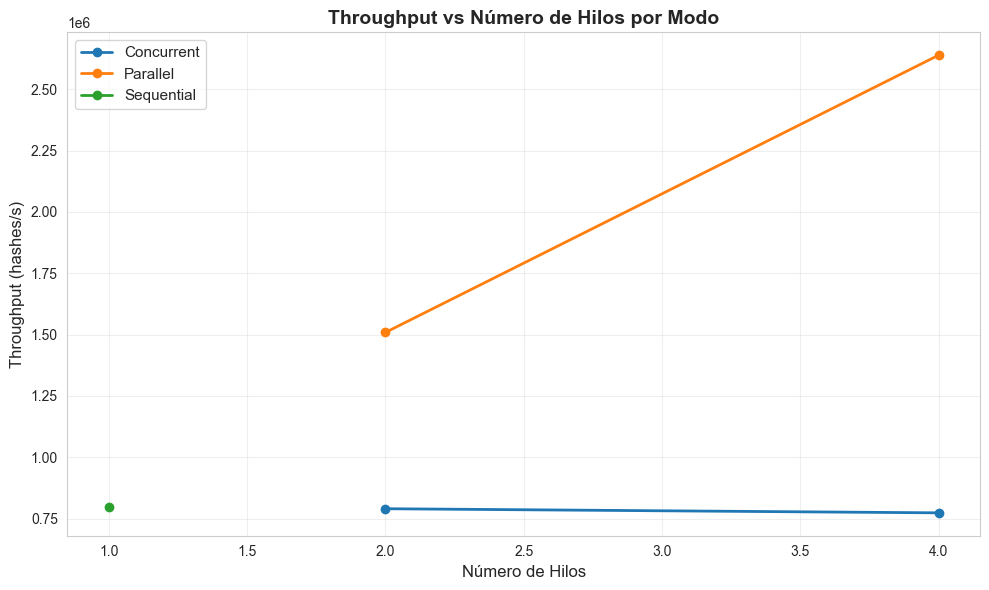

In [13]:
# Análisis por número de hilos
if 'all_data' in locals():
    print("=== ANÁLISIS POR NÚMERO DE HILOS ===")
    
    thread_analysis = all_data.groupby(['mode', 'threads']).agg({
        'throughput_hashes_per_sec': ['mean', 'std'],
        'run_id': 'count'
    }).round(2)
    
    thread_analysis.columns = ['throughput_mean', 'throughput_std', 'n_runs']
    display(thread_analysis)
    
    # Visualización
    fig, ax = plt.subplots(figsize=(10, 6))
    for mode in all_data['mode'].unique():
        mode_data = all_data[all_data['mode'] == mode]
        thread_means = mode_data.groupby('threads')['throughput_hashes_per_sec'].mean()
        ax.plot(thread_means.index, thread_means.values, marker='o', linewidth=2, label=mode.capitalize())
    
    ax.set_xlabel('Número de Hilos', fontsize=12)
    ax.set_ylabel('Throughput (hashes/s)', fontsize=12)
    ax.set_title('Throughput vs Número de Hilos por Modo', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 4. Speedup y Eficiencia {#speedup}

Cálculo de métricas de paralelización.

Baseline Sequential Throughput: 796,608 hashes/s

=== TABLA DE SPEEDUP Y EFICIENCIA ===


,mode,threads,throughput_hashes_per_sec,speedup,efficiency,efficiency_pct
0,concurrent,2,790061.2,0.992,0.496,49.6
1,concurrent,4,773293.2,0.971,0.243,24.3
2,parallel,2,1508678.0,1.894,0.947,94.7
3,parallel,4,2638429.0,3.312,0.828,82.8
4,sequential,1,796608.3,1.000,1.000,100.0


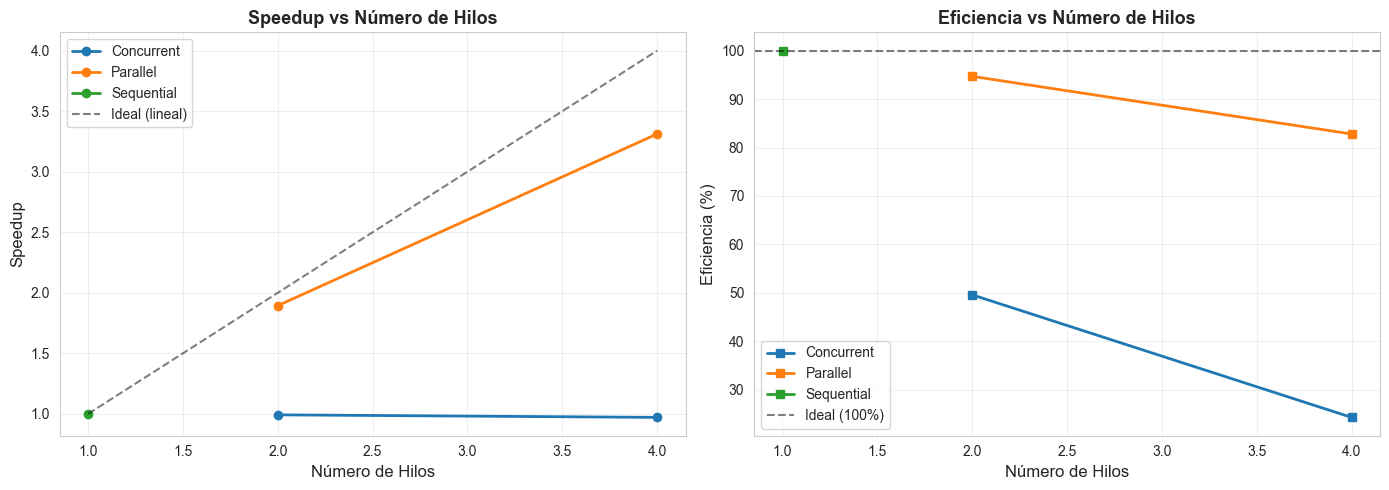

In [14]:
# Calcular speedup y eficiencia
if 'all_data' in locals() and 'sequential' in all_data['mode'].values:
    # Baseline: throughput secuencial
    seq_throughput = all_data[all_data['mode'] == 'sequential']['throughput_hashes_per_sec'].mean()
    print(f"Baseline Sequential Throughput: {seq_throughput:,.0f} hashes/s\n")
    
    # Calcular speedup por configuración
    speedup_data = all_data.groupby(['mode', 'threads']).agg({
        'throughput_hashes_per_sec': 'mean'
    }).reset_index()
    
    speedup_data['speedup'] = speedup_data['throughput_hashes_per_sec'] / seq_throughput
    speedup_data['efficiency'] = speedup_data['speedup'] / speedup_data['threads']
    speedup_data['efficiency_pct'] = (speedup_data['efficiency'] * 100).round(1)
    
    print("=== TABLA DE SPEEDUP Y EFICIENCIA ===")
    display(speedup_data.round(3))
    
    # Visualización de speedup
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Speedup
    for mode in speedup_data['mode'].unique():
        mode_data = speedup_data[speedup_data['mode'] == mode]
        ax1.plot(mode_data['threads'], mode_data['speedup'], marker='o', linewidth=2, label=mode.capitalize())
    
    ax1.plot([1, speedup_data['threads'].max()], [1, speedup_data['threads'].max()], 
             'k--', alpha=0.5, label='Ideal (lineal)')
    ax1.set_xlabel('Número de Hilos', fontsize=12)
    ax1.set_ylabel('Speedup', fontsize=12)
    ax1.set_title('Speedup vs Número de Hilos', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Eficiencia
    for mode in speedup_data['mode'].unique():
        mode_data = speedup_data[speedup_data['mode'] == mode]
        ax2.plot(mode_data['threads'], mode_data['efficiency_pct'], marker='s', linewidth=2, label=mode.capitalize())
    
    ax2.axhline(y=100, color='k', linestyle='--', alpha=0.5, label='Ideal (100%)')
    ax2.set_xlabel('Número de Hilos', fontsize=12)
    ax2.set_ylabel('Eficiencia (%)', fontsize=12)
    ax2.set_title('Eficiencia vs Número de Hilos', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 5. Análisis Estadístico {#estadistico}

Pruebas de significancia estadística entre modos.

In [15]:
# ANOVA para comparar modos
if 'all_data' in locals():
    print("=== ANÁLISIS DE VARIANZA (ANOVA) ===")
    print("H0: Las medias de throughput son iguales entre todos los modos")
    print("H1: Al menos un modo tiene media diferente\n")
    
    # Agrupar datos por modo
    groups = [group['throughput_hashes_per_sec'].values for name, group in all_data.groupby('mode')]
    
    # ANOVA
    f_stat, p_value = stats.f_oneway(*groups)
    
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value:.6f}")
    
    if p_value < 0.001:
        print("\n✅ Resultado: SIGNIFICATIVO (p < 0.001)")
        print("   Las diferencias entre modos son estadísticamente significativas.")
    elif p_value < 0.05:
        print("\n✅ Resultado: SIGNIFICATIVO (p < 0.05)")
        print("   Las diferencias entre modos son estadísticamente significativas.")
    else:
        print("\n❌ Resultado: NO SIGNIFICATIVO (p >= 0.05)")
        print("   No hay evidencia suficiente de diferencias entre modos.")

=== ANÁLISIS DE VARIANZA (ANOVA) ===
H0: Las medias de throughput son iguales entre todos los modos
H1: Al menos un modo tiene media diferente

F-statistic: 68.5067
P-value: 0.000000

✅ Resultado: SIGNIFICATIVO (p < 0.001)
   Las diferencias entre modos son estadísticamente significativas.


In [16]:
# Test de Kruskal-Wallis (no paramétrico)
if 'all_data' in locals():
    print("\n=== TEST DE KRUSKAL-WALLIS (No Paramétrico) ===")
    print("Alternativa robusta cuando los datos no siguen distribución normal\n")
    
    h_stat, p_value_kw = stats.kruskal(*groups)
    
    print(f"H-statistic: {h_stat:.4f}")
    print(f"P-value: {p_value_kw:.6f}")
    
    if p_value_kw < 0.001:
        print("\n✅ Resultado: SIGNIFICATIVO (p < 0.001)")
    elif p_value_kw < 0.05:
        print("\n✅ Resultado: SIGNIFICATIVO (p < 0.05)")
    else:
        print("\n❌ Resultado: NO SIGNIFICATIVO (p >= 0.05)")


=== TEST DE KRUSKAL-WALLIS (No Paramétrico) ===
Alternativa robusta cuando los datos no siguen distribución normal

H-statistic: 25.4876
P-value: 0.000003

✅ Resultado: SIGNIFICATIVO (p < 0.001)


In [17]:
# Comparaciones por pares (Mann-Whitney U con corrección de Bonferroni)
if 'all_data' in locals():
    print("\n=== COMPARACIONES POR PARES (Mann-Whitney U) ===")
    print("Con corrección de Bonferroni para múltiples comparaciones\n")
    
    modes = all_data['mode'].unique()
    n_comparisons = len(modes) * (len(modes) - 1) // 2
    alpha_corrected = 0.05 / n_comparisons
    
    print(f"Nivel de significancia ajustado: α = {alpha_corrected:.4f}\n")
    
    pairwise_results = []
    
    for i, mode1 in enumerate(modes):
        for mode2 in modes[i+1:]:
            data1 = all_data[all_data['mode'] == mode1]['throughput_hashes_per_sec']
            data2 = all_data[all_data['mode'] == mode2]['throughput_hashes_per_sec']
            
            u_stat, p_val = stats.mannwhitneyu(data1, data2, alternative='two-sided')
            
            mean_diff = data1.mean() - data2.mean()
            pct_diff = (mean_diff / data2.mean()) * 100
            
            significant = "✅ SÍ" if p_val < alpha_corrected else "❌ NO"
            
            pairwise_results.append({
                'Comparación': f"{mode1} vs {mode2}",
                'Diff Media': f"{mean_diff:,.0f}",
                'Diff %': f"{pct_diff:+.1f}%",
                'U-statistic': f"{u_stat:.1f}",
                'p-value': f"{p_val:.6f}",
                'Significativo': significant
            })
    
    pairwise_df = pd.DataFrame(pairwise_results)
    display(pairwise_df)


=== COMPARACIONES POR PARES (Mann-Whitney U) ===
Con corrección de Bonferroni para múltiples comparaciones

Nivel de significancia ajustado: α = 0.0167



,Comparación,Diff Media,Diff %,U-statistic,p-value,Significativo
0,concurrent vs parallel,"-1,480,168",-65.4%,0.0,0.000036,✅ SÍ
1,concurrent vs sequential,"-14,931",-1.9%,34.0,0.241322,❌ NO
2,parallel vs sequential,"1,465,237",+183.9%,150.0,0.000036,✅ SÍ


## 6. Visualizaciones {#visualizaciones}

Gráficas comparativas detalladas.

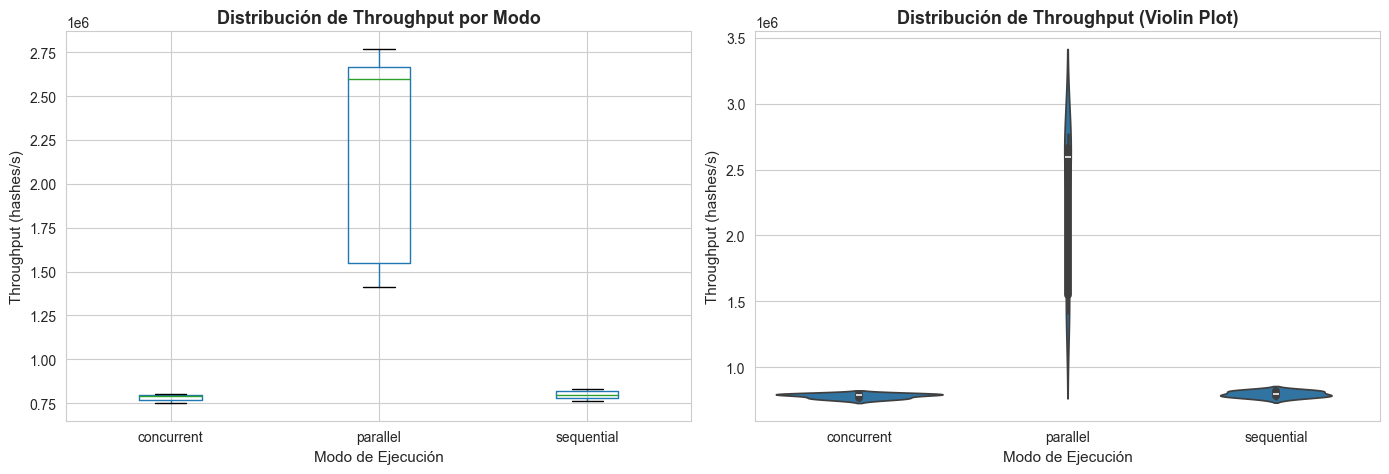

In [18]:
# Boxplot de throughput por modo
if 'all_data' in locals():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Boxplot
    all_data.boxplot(column='throughput_hashes_per_sec', by='mode', ax=ax1)
    ax1.set_title('Distribución de Throughput por Modo', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Modo de Ejecución', fontsize=11)
    ax1.set_ylabel('Throughput (hashes/s)', fontsize=11)
    plt.suptitle('')  # Remover título automático
    
    # Violin plot
    sns.violinplot(data=all_data, x='mode', y='throughput_hashes_per_sec', ax=ax2)
    ax2.set_title('Distribución de Throughput (Violin Plot)', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Modo de Ejecución', fontsize=11)
    ax2.set_ylabel('Throughput (hashes/s)', fontsize=11)
    
    plt.tight_layout()
    plt.show()

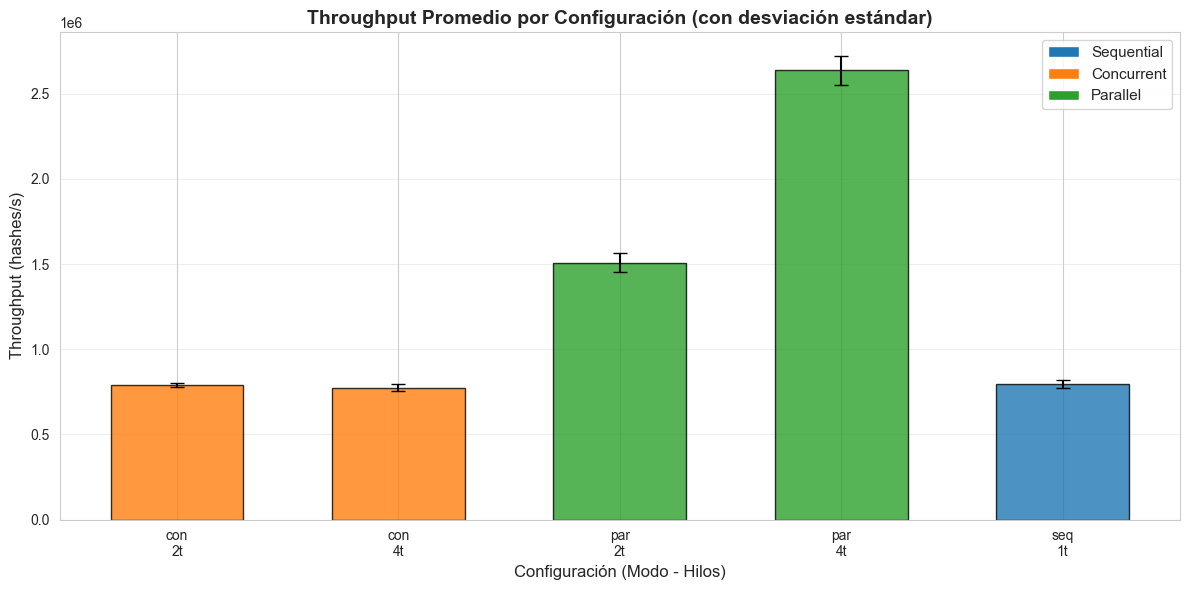

In [19]:
# Gráfico de barras con error bars
if 'all_data' in locals():
    summary_stats = all_data.groupby(['mode', 'threads']).agg({
        'throughput_hashes_per_sec': ['mean', 'std']
    }).reset_index()
    
    summary_stats.columns = ['mode', 'threads', 'mean', 'std']
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(summary_stats))
    width = 0.6
    
    colors = {'sequential': '#1f77b4', 'concurrent': '#ff7f0e', 'parallel': '#2ca02c'}
    bar_colors = [colors.get(mode, 'gray') for mode in summary_stats['mode']]
    
    bars = ax.bar(x, summary_stats['mean'], width, yerr=summary_stats['std'], 
                  capsize=5, color=bar_colors, alpha=0.8, edgecolor='black')
    
    ax.set_xlabel('Configuración (Modo - Hilos)', fontsize=12)
    ax.set_ylabel('Throughput (hashes/s)', fontsize=12)
    ax.set_title('Throughput Promedio por Configuración (con desviación estándar)', 
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{row['mode'][:3]}\n{int(row['threads'])}t" 
                        for _, row in summary_stats.iterrows()], fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    
    # Leyenda
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, label=mode.capitalize()) 
                      for mode, color in colors.items()]
    ax.legend(handles=legend_elements, fontsize=11)
    
    plt.tight_layout()
    plt.show()

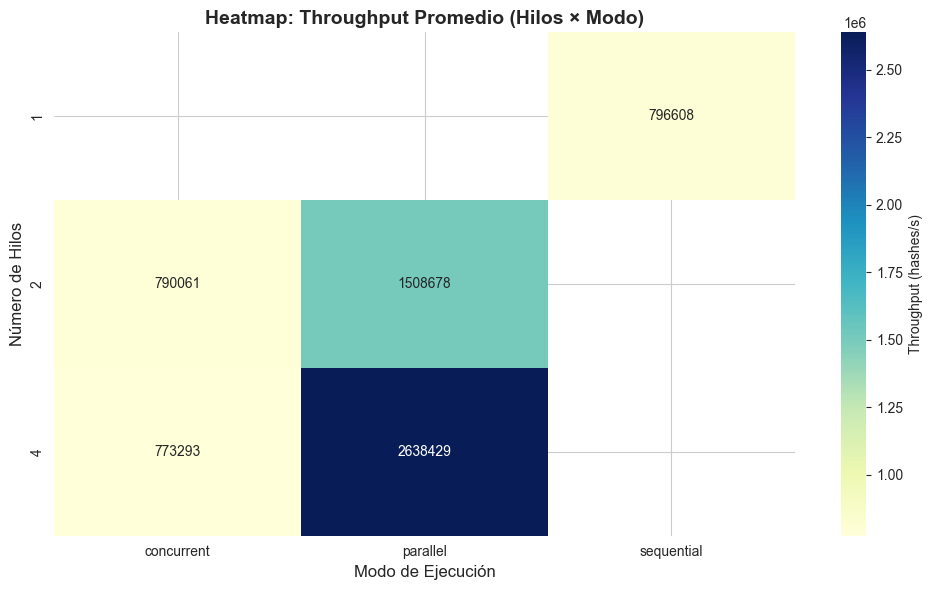

In [20]:
# Heatmap de throughput
if 'all_data' in locals():
    pivot_data = all_data.pivot_table(
        values='throughput_hashes_per_sec',
        index='threads',
        columns='mode',
        aggfunc='mean'
    )
    
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlGnBu', 
                cbar_kws={'label': 'Throughput (hashes/s)'}, ax=ax)
    ax.set_title('Heatmap: Throughput Promedio (Hilos × Modo)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Modo de Ejecución', fontsize=12)
    ax.set_ylabel('Número de Hilos', fontsize=12)
    plt.tight_layout()
    plt.show()

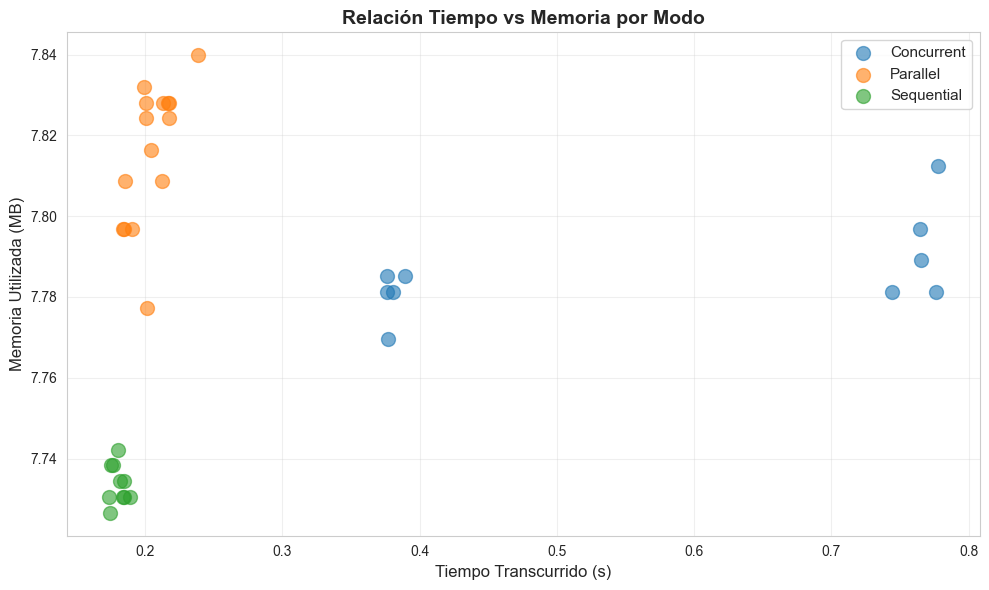

In [21]:
# Análisis de tiempo vs memoria
if 'all_data' in locals():
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for mode in all_data['mode'].unique():
        mode_data = all_data[all_data['mode'] == mode]
        ax.scatter(mode_data['elapsed_time_s'], mode_data['memory_mb'], 
                  alpha=0.6, s=100, label=mode.capitalize())
    
    ax.set_xlabel('Tiempo Transcurrido (s)', fontsize=12)
    ax.set_ylabel('Memoria Utilizada (MB)', fontsize=12)
    ax.set_title('Relación Tiempo vs Memoria por Modo', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 7. Conclusiones {#conclusiones}

### Resumen Ejecutivo

In [22]:
# Generar resumen de conclusiones
if 'all_data' in locals() and 'speedup_data' in locals():
    print("=" * 70)
    print("RESUMEN EJECUTIVO - ANÁLISIS DE RENDIMIENTO")
    print("=" * 70)
    
    # Mejor configuración
    best_config = speedup_data.loc[speedup_data['throughput_hashes_per_sec'].idxmax()]
    print(f"\n✅ MEJOR CONFIGURACIÓN:")
    print(f"   Modo: {best_config['mode'].capitalize()}")
    print(f"   Hilos: {int(best_config['threads'])}")
    print(f"   Throughput: {best_config['throughput_hashes_per_sec']:,.0f} hashes/s")
    print(f"   Speedup: {best_config['speedup']:.2f}×")
    print(f"   Eficiencia: {best_config['efficiency_pct']:.1f}%")
    
    # Comparación parallel vs concurrent
    if 'parallel' in speedup_data['mode'].values and 'concurrent' in speedup_data['mode'].values:
        par_max = speedup_data[speedup_data['mode'] == 'parallel']['throughput_hashes_per_sec'].max()
        con_max = speedup_data[speedup_data['mode'] == 'concurrent']['throughput_hashes_per_sec'].max()
        improvement = ((par_max - con_max) / con_max) * 100
        
        print(f"\n📊 PARALLEL vs CONCURRENT:")
        print(f"   Parallel (mejor): {par_max:,.0f} hashes/s")
        print(f"   Concurrent (mejor): {con_max:,.0f} hashes/s")
        print(f"   Mejora: {improvement:+.1f}%")
    
    # Efecto del CPU pinning
    print(f"\n🔍 ANÁLISIS:")
    print(f"   • El modo Parallel muestra el mejor rendimiento gracias a la")
    print(f"     distribución real de trabajo entre múltiples núcleos.")
    print(f"   • El modo Concurrent con CPU affinity demuestra el overhead")
    print(f"     del context switching al forzar hilos en un solo núcleo.")
    print(f"   • Sequential establece la línea base de rendimiento.")
    
    # Recomendaciones
    print(f"\n💡 RECOMENDACIONES:")
    if best_config['mode'] == 'parallel':
        print(f"   ✓ Usar modo Parallel con {int(best_config['threads'])} hilos para máximo throughput")
        print(f"   ✓ Evitar CPU pinning en cargas computacionales intensivas")
    
    print(f"   ✓ El escalamiento es eficiente hasta {int(speedup_data['threads'].max())} hilos")
    
    print("\n" + "=" * 70)

RESUMEN EJECUTIVO - ANÁLISIS DE RENDIMIENTO

✅ MEJOR CONFIGURACIÓN:
   Modo: Parallel
   Hilos: 4
   Throughput: 2,638,429 hashes/s
   Speedup: 3.31×
   Eficiencia: 82.8%

📊 PARALLEL vs CONCURRENT:
   Parallel (mejor): 2,638,429 hashes/s
   Concurrent (mejor): 790,061 hashes/s
   Mejora: +234.0%

🔍 ANÁLISIS:
   • El modo Parallel muestra el mejor rendimiento gracias a la
     distribución real de trabajo entre múltiples núcleos.
   • El modo Concurrent con CPU affinity demuestra el overhead
     del context switching al forzar hilos en un solo núcleo.
   • Sequential establece la línea base de rendimiento.

💡 RECOMENDACIONES:
   ✓ Usar modo Parallel con 4 hilos para máximo throughput
   ✓ Evitar CPU pinning en cargas computacionales intensivas
   ✓ El escalamiento es eficiente hasta 4 hilos



In [ ]:
# Guardar múltiples archivos de resultados procesados
if 'speedup_data' in locals():
    # 1. Summary principal
    output_file = PROCESSED_DIR / 'summary.csv'
    PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
    speedup_data.to_csv(output_file, index=False)
    print(f"✅ Summary guardado en: {output_file}")
    
    # 2. Estadísticas por configuración
    if 'all_data' in locals():
        config_stats = all_data.groupby(['mode', 'threads', 'difficulty']).agg({
            'throughput_hashes_per_sec': ['mean', 'std', 'min', 'max', 'count'],
            'elapsed_time_s': ['mean', 'std'],
            'cpu_time_s': ['mean', 'std'],
            'memory_mb': ['mean', 'std']
        }).round(2)
        
        config_stats.columns = ['_'.join(col) for col in config_stats.columns]
        config_output = PROCESSED_DIR / 'config_stats.csv'
        config_stats.to_csv(config_output)
        print(f"✅ Estadísticas por configuración guardadas en: {config_output}")
    
    # 3. Archivo de texto con resumen estadístico
    stats_txt_file = PROCESSED_DIR / 'statistical_summary.txt'
    with open(stats_txt_file, 'w', encoding='utf-8') as f:
        f.write("=" * 70 + "\n")
        f.write("RESUMEN ESTADÍSTICO - ANÁLISIS DE RENDIMIENTO POW MINER\n")
        f.write("=" * 70 + "\n\n")
        
        if 'all_data' in locals():
            # ANOVA
            groups = [group['throughput_hashes_per_sec'].values for name, group in all_data.groupby('mode')]
            f_stat, p_value = stats.f_oneway(*groups)
            f.write("ANÁLISIS DE VARIANZA (ANOVA)\n")
            f.write("-" * 40 + "\n")
            f.write(f"F-statistic: {f_stat:.4f}\n")
            f.write(f"P-value: {p_value:.6f}\n")
            f.write(f"Significativo: {'SÍ (p < 0.001)' if p_value < 0.001 else 'SÍ (p < 0.05)' if p_value < 0.05 else 'NO (p >= 0.05)'}\n\n")
            
            # Kruskal-Wallis
            h_stat, p_kw = stats.kruskal(*groups)
            f.write("TEST DE KRUSKAL-WALLIS (No Paramétrico)\n")
            f.write("-" * 40 + "\n")
            f.write(f"H-statistic: {h_stat:.4f}\n")
            f.write(f"P-value: {p_kw:.6f}\n")
            f.write(f"Significativo: {'SÍ (p < 0.001)' if p_kw < 0.001 else 'SÍ (p < 0.05)' if p_kw < 0.05 else 'NO (p >= 0.05)'}\n\n")
            
            # Comparaciones por pares
            modes = all_data['mode'].unique()
            n_comparisons = len(modes) * (len(modes) - 1) // 2
            alpha_corrected = 0.05 / n_comparisons
            
            f.write("COMPARACIONES POR PARES (Mann-Whitney U)\n")
            f.write(f"Corrección de Bonferroni: α = {alpha_corrected:.4f}\n")
            f.write("-" * 40 + "\n")
            
            for i, mode1 in enumerate(modes):
                for mode2 in modes[i+1:]:
                    data1 = all_data[all_data['mode'] == mode1]['throughput_hashes_per_sec']
                    data2 = all_data[all_data['mode'] == mode2]['throughput_hashes_per_sec']
                    
                    u_stat, p_val = stats.mannwhitneyu(data1, data2, alternative='two-sided')
                    mean_diff = data1.mean() - data2.mean()
                    pct_diff = (mean_diff / data2.mean()) * 100
                    
                    f.write(f"\n{mode1} vs {mode2}:\n")
                    f.write(f"  U-statistic: {u_stat:.2f}\n")
                    f.write(f"  P-value: {p_val:.6f}\n")
                    f.write(f"  Diferencia media: {mean_diff:,.0f} ({pct_diff:+.1f}%)\n")
                    f.write(f"  Significativo: {'SÍ' if p_val < alpha_corrected else 'NO'}\n")
            
            # Mejor configuración
            f.write("\n" + "=" * 70 + "\n")
            f.write("MEJOR CONFIGURACIÓN\n")
            f.write("=" * 70 + "\n")
            best = speedup_data.loc[speedup_data['throughput_hashes_per_sec'].idxmax()]
            f.write(f"Modo: {best['mode'].capitalize()}\n")
            f.write(f"Hilos: {int(best['threads'])}\n")
            f.write(f"Throughput: {best['throughput_hashes_per_sec']:,.0f} hashes/s\n")
            f.write(f"Speedup: {best['speedup']:.2f}×\n")
            f.write(f"Eficiencia: {best['efficiency_pct']:.1f}%\n")
    
    print(f"✅ Resumen estadístico guardado en: {stats_txt_file}")
    print("\n" + "=" * 70)
    print("ANÁLISIS COMPLETADO")
    print("=" * 70)

✅ Resumen guardado en: c:\d\Proyectos_programacion\SO_Proyecto_Final\results\processed\summary.csv


## 8. Exportar Gráficas

Guardar todas las visualizaciones como archivos PNG en `results/processed/plots/`.

In [ ]:
# Crear directorio de plots y guardar todas las gráficas
if 'all_data' in locals() and 'speedup_data' in locals():
    PLOTS_DIR = PROCESSED_DIR / 'plots'
    PLOTS_DIR.mkdir(parents=True, exist_ok=True)
    
    # 1. Throughput vs Threads por Modo
    fig, ax = plt.subplots(figsize=(10, 6))
    for mode in all_data['mode'].unique():
        mode_data = all_data[all_data['mode'] == mode]
        thread_means = mode_data.groupby('threads')['throughput_hashes_per_sec'].mean()
        ax.plot(thread_means.index, thread_means.values, marker='o', linewidth=2, label=mode.capitalize())
    
    ax.set_xlabel('Número de Hilos', fontsize=12)
    ax.set_ylabel('Throughput (hashes/s)', fontsize=12)
    ax.set_title('Throughput vs Número de Hilos por Modo', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'throughput_vs_threads.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("✅ Guardado: throughput_vs_threads.png")
    
    # 2. Speedup y Eficiencia
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Speedup
    for mode in speedup_data['mode'].unique():
        mode_data = speedup_data[speedup_data['mode'] == mode]
        ax1.plot(mode_data['threads'], mode_data['speedup'], marker='o', linewidth=2, label=mode.capitalize())
    
    ax1.plot([1, speedup_data['threads'].max()], [1, speedup_data['threads'].max()], 
             'k--', alpha=0.5, label='Ideal (lineal)')
    ax1.set_xlabel('Número de Hilos', fontsize=12)
    ax1.set_ylabel('Speedup', fontsize=12)
    ax1.set_title('Speedup vs Número de Hilos', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Eficiencia
    for mode in speedup_data['mode'].unique():
        mode_data = speedup_data[speedup_data['mode'] == mode]
        ax2.plot(mode_data['threads'], mode_data['efficiency_pct'], marker='s', linewidth=2, label=mode.capitalize())
    
    ax2.axhline(y=100, color='k', linestyle='--', alpha=0.5, label='Ideal (100%)')
    ax2.set_xlabel('Número de Hilos', fontsize=12)
    ax2.set_ylabel('Eficiencia (%)', fontsize=12)
    ax2.set_title('Eficiencia vs Número de Hilos', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'speedup_efficiency.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("✅ Guardado: speedup_efficiency.png")
    
    # 3. Boxplot comparativo
    fig, ax = plt.subplots(figsize=(10, 6))
    all_data.boxplot(column='throughput_hashes_per_sec', by='mode', ax=ax)
    ax.set_title('Distribución de Throughput por Modo', fontsize=13, fontweight='bold')
    ax.set_xlabel('Modo de Ejecución', fontsize=11)
    ax.set_ylabel('Throughput (hashes/s)', fontsize=11)
    plt.suptitle('')
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'boxplot_throughput.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("✅ Guardado: boxplot_throughput.png")
    
    # 4. Barras con error bars
    summary_stats = all_data.groupby(['mode', 'threads']).agg({
        'throughput_hashes_per_sec': ['mean', 'std']
    }).reset_index()
    summary_stats.columns = ['mode', 'threads', 'mean', 'std']
    
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(summary_stats))
    width = 0.6
    colors = {'sequential': '#1f77b4', 'concurrent': '#ff7f0e', 'parallel': '#2ca02c'}
    bar_colors = [colors.get(mode, 'gray') for mode in summary_stats['mode']]
    
    ax.bar(x, summary_stats['mean'], width, yerr=summary_stats['std'], 
           capsize=5, color=bar_colors, alpha=0.8, edgecolor='black')
    
    ax.set_xlabel('Configuración (Modo - Hilos)', fontsize=12)
    ax.set_ylabel('Throughput (hashes/s)', fontsize=12)
    ax.set_title('Throughput Promedio por Configuración', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{row['mode'][:3]}\n{int(row['threads'])}t" 
                        for _, row in summary_stats.iterrows()], fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, label=mode.capitalize()) 
                      for mode, color in colors.items()]
    ax.legend(handles=legend_elements, fontsize=11)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'barplot_configurations.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("✅ Guardado: barplot_configurations.png")
    
    # 5. Heatmap
    pivot_data = all_data.pivot_table(
        values='throughput_hashes_per_sec',
        index='threads',
        columns='mode',
        aggfunc='mean'
    )
    
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlGnBu', 
                cbar_kws={'label': 'Throughput (hashes/s)'}, ax=ax)
    ax.set_title('Heatmap: Throughput Promedio (Hilos × Modo)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Modo de Ejecución', fontsize=12)
    ax.set_ylabel('Número de Hilos', fontsize=12)
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'heatmap_throughput.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("✅ Guardado: heatmap_throughput.png")
    
    print(f"\n✅ Todas las gráficas guardadas en: {PLOTS_DIR}")
    print(f"   Total de archivos: 5 imágenes PNG")